In [1]:
%matplotlib inline
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.fftpack import dct
import soundfile as sf
import matplotlib.pyplot as plt

In [2]:
root = './'

pre_emphasis = 0.97
frame_size = 0.025
frame_stride = 0.01
NFFT = 512
nfilt = 40
num_ceps = 12
cep_lifter = 22

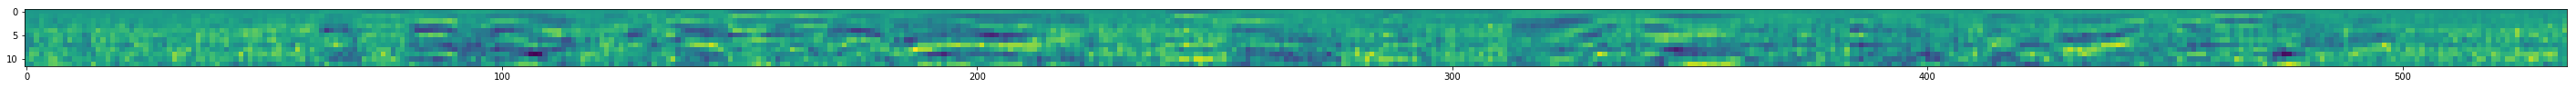

In [3]:
for file in tf.gfile.Open(root + 'wsj0/transcripts/wsj0/wsj0.ctl').readlines():
    #signal, sample_rate = sf.read(tf.gfile.Open(root + file.rstrip('\n') + '.flac'))
    signal, sample_rate = sf.read(root + file.rstrip('\n') + '.flac')
    
    # http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
    
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    frames *= np.hamming(frame_length)
    
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
    
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift  #*
    
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    
    plt.figure(figsize=(50,10))
    plt.imshow(mfcc.T)

    break